In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
mean = pd.read_csv("gdrive/My Drive/Colab Notebooks/Descartes Underwriting/MEAN_AUTO.csv", sep=',')
shell = pd.read_csv("gdrive/My Drive/Colab Notebooks/Descartes Underwriting/SHELL_AUTO.csv", sep=',')
train = pd.read_csv("gdrive/My Drive/Colab Notebooks/Descartes Underwriting/train_auto.csv", sep=',')
test = pd.read_csv("gdrive/My Drive/Colab Notebooks/Descartes Underwriting/test_auto.csv", sep=',')

Mounted at /content/gdrive


PROBLEMATIQUE

In [2]:
train.head()

# La cible de ce projet est la colonne TARGET_FLAG

# Si l'on observe le dataset, on voit qu'il contient des profils clients
# En observant la colonne, on remarque qu'il s'agit d'un booleen : 0 ou 1
# L'objectif de ce modèle est donc certainement de caractériser un client donné afin de savoir s'il est sensible ou non à tel critère

# On peut donc affirmer que le projet suivant correspond à un problème de classification supervisée

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


PREPROCESSING



In [3]:
train.isnull().sum()

# Observons dans un premier temps si le dataset contient un grand nombre de valeurs nulles
# On notera ainsi les colonnes YOJ, INCOME, HOME_VAL, JOB et CAR_AGE qui sont vide à 6%
# C'est un pourcentage acceptable

INDEX            0
TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

In [4]:
# En observant le jeu de données, on remarque également que certaines valeurs ont les caractères "z_"
# Il peut s'agir d'un marqueur voulu car si l'on regarde la colonne SEX par exemple, on remarque qu'il n'y a bien que deux valeurs distinctes "M" et "z_F"
# Il en va de même pour les autres colonnes concernées

train.nunique()

# On remarque également qu'il y a 8161 id différents ce qui montre qu'il n'y a probablement pas de doublons dans le dataset

INDEX          8161
TARGET_FLAG       2
TARGET_AMT     1949
KIDSDRIV          5
AGE              60
HOMEKIDS          6
YOJ              21
INCOME         6612
PARENT1           2
HOME_VAL       5106
MSTATUS           2
SEX               2
EDUCATION         5
JOB               8
TRAVTIME         97
CAR_USE           2
BLUEBOOK       2789
TIF              23
CAR_TYPE          6
RED_CAR           2
OLDCLAIM       2857
CLM_FREQ          6
REVOKED           2
MVR_PTS          13
CAR_AGE          30
URBANICITY        2
dtype: int64

In [5]:
# Comme nous n'avons pas plus d'informations, je considère que ce marqueur n'est pas voulu et vais donc nettoyer le dataset de ce marqueur

replacements = {"z_F":"F", "z_No": "no", "No": "no", "Yes": "yes", "z_High School":"High School", "z_SUV":"SUV", "z_Blue Collar":"Blue Collar", "<High School":"Middle School", "z_Highly Rural/ Rural":"Highly Rural/ Rural"}

# Je suppose ici que "<High School" de la colonne EDUCATION signifie "à étudier moins que le lycée"
# Je le remplace donc par quelque chose de plus clair
# Je change les également les "Yes" en "yes" (idem pour "No") afin d'uniformiser la donnée

train = train.replace(replacements)
test = test.replace(replacements)

In [6]:
# Pour pouvoir exploiter la donnée numérique des salaires, je vais également enlever le symbole "$" des prix
# On peut se permettre d'enlever cette information car tous ces valeurs sont en dollars
# Dans le cas où différentes monnaies sont utilisées, on pourrait rajouter une colonne "CURRENCY" contenant la monnaie sous forme de tag comme "EUR" et "USD"
# Ici, je me permet de ne pas le faire pour éviter d'avoir une colonne remplie exclusivement de "USD"

columnsWithDollar = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
for column in columnsWithDollar:    
    train[column] = train[column].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|', "")
    test[column] = test[column].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|', "")

In [7]:
train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,67349,no,0,no,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,no,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,91449,no,257252,no,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,no,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,16039,no,124191,yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,no,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,no,306251,yes,M,Middle School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,no,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,114986,no,243925,yes,F,PhD,Doctor,36,Private,18000,1,SUV,no,19217,2,yes,3,17.0,Highly Urban/ Urban


In [8]:
# Les colonnes qui possédaient un prix sont toujours considérées comme contenant des strings
# Changeons les en float, et profitons en pour changer toutes les colonnes ayant une valeur numérique en float

columnToConvertToFloat = ["TARGET_FLAG", "KIDSDRIV", "HOMEKIDS", "INCOME", "HOME_VAL", "TRAVTIME", "BLUEBOOK", "OLDCLAIM", "TIF", "CLM_FREQ", "MVR_PTS"]
for column in columnToConvertToFloat:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)

In [9]:
# En observant le dataset, on remarque également que la colonne "CAR_AGE" par exemple, contient une valeur négative, ce qui est absurde
# Plusieurs choix s'offrent à nous
# On peut remplacer cette valeur par 0 et considérer qu'il s'agit d'une erreur
# On peut remplacer cette valeur par un NaN pour 
# Supprimer la ligne car on suppose que si cette valeur est absurde, toute la ligne l'est
# Ici, je fais le choix de set la valeur sur NaN

columnsWithNumericalValue = ["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "INCOME", "HOME_VAL", "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM", "CLM_FREQ", "MVR_PTS", "CAR_AGE"]

for index, row in train.iterrows():
    for column in columnsWithNumericalValue:
        if row[column] < 0:
            train.at[index, column] = float('NaN')

for index, row in test.iterrows():
    for column in columnsWithNumericalValue:
        if row[column] < 0:
            test.at[index, column] = float('NaN')

In [10]:
# Enfin, transformons les données qualitatives et les booléens yes/no en données catégorielles
# Le float assigné à chaque catégorie est arbitraire

replacements = {"no":float(0), "yes":float(1), 
                "M":float(0), "F":float(1),
                "Middle School":float(0), "High School":float(1), "Bachelors":float(2), "Masters":float(3), "PhD":float(4),
                "Clerical":float(0), "Doctor":float(1), "Home Maker":float(2), "Lawyer":float(3), "Manager":float(4), "Professional":float(5), "Student":float(6), "Blue Collar":float(7),
                "Commercial":float(0), "Private":float(1),
                "Minivan":float(0), "Panel Truck":float(1), "Pickup":float(2), "Sports Car":float(3), "Van":float(4), "SUV":float(5),
                "Highly Urban/ Urban":float(0), "Highly Rural/ Rural":float(1)
                }

train = train.replace(replacements)
test = test.replace(replacements)

In [11]:
  # Faisons maintenant une copie du dataframe train qui ne contient aucun NaN afin d'avoir les données les plus complètes possible
  trainWithoutNaN = train.copy()
  testWithoutNaN = test.copy()

In [12]:
trainWithoutNaN = trainWithoutNaN.dropna()

testWithoutNaN = testWithoutNaN.drop(columns=["TARGET_FLAG", "TARGET_AMT"]) # Pour le dataframe test, on drop d'abord les colonnes que l'on cherche à prédire car elles sont toutes vides
testWithoutNaN = testWithoutNaN.dropna()

# Si l'on regarde le nombre de ligne, on passe ainsi de 8161 lignes à 6044

In [13]:
trainWithoutNaN.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0.0,0.0,0.0,60.0,0.0,11.0,67349.0,0.0,0.0,0.0,0.0,4.0,5.0,14.0,1.0,14230.0,11.0,0.0,1.0,4461.0,2.0,0.0,3.0,18.0,0.0
1,2,0.0,0.0,0.0,43.0,0.0,11.0,91449.0,0.0,257252.0,0.0,0.0,1.0,7.0,22.0,0.0,14940.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,35.0,1.0,10.0,16039.0,0.0,124191.0,1.0,1.0,1.0,0.0,5.0,1.0,4010.0,4.0,5.0,0.0,38690.0,2.0,0.0,3.0,10.0,0.0
5,7,1.0,2946.0,0.0,34.0,1.0,12.0,125301.0,1.0,0.0,0.0,1.0,2.0,7.0,46.0,0.0,17430.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
8,12,1.0,2501.0,0.0,34.0,0.0,10.0,62978.0,0.0,0.0,0.0,1.0,2.0,0.0,34.0,1.0,11200.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
trainWithoutNaN.isnull().sum()
# Toutes les lignes contenant un NaN ont bien été enlevé

INDEX          0
TARGET_FLAG    0
TARGET_AMT     0
KIDSDRIV       0
AGE            0
HOMEKIDS       0
YOJ            0
INCOME         0
PARENT1        0
HOME_VAL       0
MSTATUS        0
SEX            0
EDUCATION      0
JOB            0
TRAVTIME       0
CAR_USE        0
BLUEBOOK       0
TIF            0
CAR_TYPE       0
RED_CAR        0
OLDCLAIM       0
CLM_FREQ       0
REVOKED        0
MVR_PTS        0
CAR_AGE        0
URBANICITY     0
dtype: int64

HYPOTHESES

In [15]:
# Difficile d'établir une hypothèse sur quelles variables utiliser pour prédire TARGET_FLAG puisqu'on ne sait pas à quoi correspond cette variable

MODELE

In [16]:
# Comme modèle, je choisis de faire un Linear SVC car :
# Ce modèle à l'avantage d'être simple à interpréter et est donc parfait pour un premier essai
# L'objectif est de prédire une catégorie : TARGET_FLAG = 0 ou 1
# Les données sont labelisées
# Le nombre de données ne se compte pas en centaines de milliers

In [17]:
# Transformons nos données au format de numpy pour utiliser le svm de sklearn

XToNP = trainWithoutNaN.drop(columns=["INDEX", "TARGET_FLAG", "TARGET_AMT"])
yToNP = trainWithoutNaN["TARGET_FLAG"]

In [18]:
X = XToNP.to_numpy()
y = yToNP.to_numpy() # Colonne que l'on cherche à prédire

In [19]:
X = X.astype(int)
y = y.astype(int)

In [20]:
X.shape[0] == y.shape[0]
# La taille est bien identique

True

In [21]:
Xsmall = X[:1000]
ysmall = y[:1000]
# Pour rendre le calcul plus rapide, prenons un petit échantillon

In [22]:
# Testons un premier modèle avec les paramètres de bases
clf = svm.SVC(kernel='linear', C = 1.0)

In [23]:
clf.fit(Xsmall,ysmall)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
# Faisons maintenant nos prédictions sur nos données de test
# Effectuons tout d'abord la même transformation vers numpy
testWithoutNaN = testWithoutNaN.drop(columns=["INDEX"])
testNP = testWithoutNaN.to_numpy()
testNP = testNP.astype(int)

In [25]:
# Effectuons maintenant les prédictions

result = []
for i in range(len(testNP)):
    result.append(clf.predict([testNP[i]]))

EXPORT

In [26]:
dfResult = pd.DataFrame(result)
dfResult.to_csv("gdrive/My Drive/Colab Notebooks/Descartes Underwriting/predictions.csv")

PERFORMANCE

In [27]:
# Pour tester les performances, nous allons prédire les valeurs du dataset de train
# A noter qu'il aurait été préférable de séparer le dataset train au préalable afin de créer un dataset de validation

trainWithoutNaN = trainWithoutNaN.drop(columns=["INDEX", "TARGET_FLAG", "TARGET_AMT"])
trainNP = trainWithoutNaN.to_numpy()
trainNP = trainNP.astype(int)

resultTrain = []
for i in range(len(trainNP)):
    resultTrain.append(clf.predict([trainNP[i]]))

In [28]:
# Mise en forme des tableaux
# Transformer les prédictions qui sont un array of array en array
arrayOfPredictions = np.array(resultTrain)
arrayOfPredictions = np.concatenate(arrayOfPredictions, axis=0)

Accuracy:  0.7281601588352085


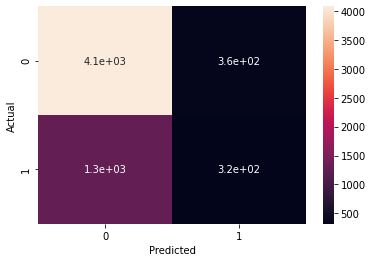

In [29]:
confusion_matrix = pd.crosstab(y, arrayOfPredictions, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',accuracy_score(y, arrayOfPredictions))
plt.show()

# La précision du modèle est de 72%
# On peut déjà affirmer que le modèle n'overfit, sinon l'accuracy serait bien plus élevé
# En regardant la matrice de confusion, on peut voir que les vrais négatifs semblent bien gérer par le modèle
# En revanche, pour l'estimation des positifs, il y a à peu près autant de vrais positifs que de faux positifs
# Le modèle est donc largement améliorable

AMELIORATION

In [30]:
# Pour améliorer les résultats, trois pistes s'offrent à nous
# Premièrement, utiliser plus de données pour entraîner le modèle pour voir si le manque de données à un impact (peu probable)
# Deuxièmement, changer de modèle
# En effet, le modèle utilisé est un SVC
# Cela pose un problème, principalement car on ne sait pas vraiment ce que représente TARGET_FLAG, on ne peut pas choisir les attributs que l'on souhaite exploiter
# Cela entraîne une grand temps de calcul, et donc un grand coût, dû à une dimension élevée, d'où l'utilisation de seulement 1000 données pour entraîner le modèle
# Troisièmement, faire un tri dans les attributs utilisés
# Se recentrer sur les attributs les plus importants

# Ma solution serait tout de même de chercher les variables les plus pertinentes, celle avec le plus de poids
# On peut également améliorer le traitement du dataset en choisissant un autre moyen pour transformer les données qualitatives en données quantitatives
# Pour améliorer les performances, on peut également séparer le dataset de train en 2 afin de créer un validation set pour valider les résultats
# Je ne pense pas que ma solution d'attribuer un index soit performante pour les données non-booléennes

# Enfin, on peut également penser à une approche probabiliste
# Cela se traduirait pas une prédiction entre 0 et 1 au lieu de soit 0, soit 1
# Cela permettrait une meilleur compréhension et interprétation des prédictions
# Mais également un meilleur repérage des valeurs "floues" (qui seraient proche de 0.5)